## 배터리 최적화(휴리스틱)

### 데이터 전처리

In [10]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd

# .mat 파일 로드

data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten().reshape(-1, 1)
clearDay = data['clearDay'].flatten().reshape(-1, 1)
loadData = data['loadData'][:, 2].reshape(-1, 1) * 10e-5
costData = data['costData'].flatten().reshape(-1, 1)


print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )



자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)


In [2]:
# Long-term simulation data code
# CSV Data load
import pandas as pd
import numpy as np
from scipy.io import loadmat
data = pd.read_csv('2020_load_data.csv')

# Long-term simulation data code
import numpy as np

# 시작 값, 끝 값, 간격 설정
start = 300
end = 86400
interval = 300

# 리스트 생성
time_intervals = list(range(start, end + interval, interval))
# numpy 배열로 변환하고 2D 배열로 reshape
# time = (np.array(time_intervals).reshape(-1, 1).flatten().reshape(-1, 1))
time = np.tile(np.array(time_intervals).reshape(-1, 1).flatten(),366)


#전력 단가 데이터
dateData = np.array(data['datetime']).reshape(-1,288,1)
dateData = dateData.flatten().reshape(-1, 1)
costData = np.array(data['price']).reshape(-1,288,1) * 300/3600
costData = costData.flatten().reshape(-1, 1)
clearDay = np.array(data['pv']).reshape(-1,288,1)
clearDay = clearDay.flatten().reshape(-1, 1)
loadData = np.array(data['load']).reshape(-1,288,1) * 5
loadData = loadData.flatten().reshape(-1, 1)
seasonData = np.array(data["season"]).reshape(-1,288,1)
seasonData = seasonData.flatten().reshape(-1, 1)


print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )
print("자료형:", type(seasonData), "차원" , seasonData.shape, )

자료형: <class 'numpy.ndarray'> 차원 (105408,)
자료형: <class 'numpy.ndarray'> 차원 (105408, 1)
자료형: <class 'numpy.ndarray'> 차원 (105408, 1)
자료형: <class 'numpy.ndarray'> 차원 (105408, 1)
자료형: <class 'numpy.ndarray'> 차원 (105408, 1)


In [3]:
time = time[0:288]
costData = costData[0:288]
clearDay = clearDay[0:288]
loadData = loadData[0:288]
seasonData = seasonData[0:288]

### 데이터 처리

In [4]:
import numpy as np
import matlab.engine
import numpy as np

# Load Power Data from Existing PV array
# Assuming pvLoadPriceData is already loaded from file

# Set up Optimization Parameters
numDays = 1  # Number of consecutive days
FinalWeight = 1.0  # Final weight on energy storage
timeOptimize = 5  # Time step for optimization [min]

H2ToalE = 100 * 33.33                  # 총 전력량(KW) = 수소 저장 탱크 * 1KG 당 발전량 
hydrogenStorage = 0.5 * H2ToalE             # 수소 탱크 초기 저장량 
maxSOC = 0.9 * H2ToalE                      # 수소의 최대 에너지 상태
minSOC = 0.2 * H2ToalE                      # 수소최소 허용 에너지 상태
Pmin = -400e3                               # 에너지가 수소로부터 방출
Pmax = 400e3                                # 에너지가 수고로 저장 

# Rescale data to align with desired time steps
stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))
clearPpv = 1 * 1 * np.tile(clearDay[1::stepAdjust], (numDays, 1))

# Adjust and Select Loading
loadFluc = np.tile(loadData[1::stepAdjust], (numDays, 1))

# # Grid Price Values [$/kWh]
C = np.tile(costData[1::stepAdjust], (numDays, 1))

# Select Desired Data for Optimization
Ppv = clearPpv
Pload = loadFluc

# Setup Time Vectors
dt = timeOptimize * 60.0
N = numDays * (len(time[::stepAdjust]) - 1) * 1.0
tvec = np.arange(1, N + 1) * dt



In [14]:
def rule_based_control(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time):
    Pgrid = np.zeros_like(Pload)  # 전력 그리드 초기화
    Phydro = np.zeros_like(Pload)
    
    for i in range(len(Pload)):
        # 8시~11시, 12시~13시, 18시~22시(여름, 봄, 가을)
        # Medium 시간대
        if ((28800 <= time[i] < 39600 or 43200 <= time[i] < 46800 or 64800 <= time[i] < 79200)) and (seasonData[i] == 2 or seasonData[i] == 3 or seasonData[i] == 4) :
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                
                Pgrid[i] = tNeedPower
                Phydro[i] = hydrogenStorage

                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage

                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))




        # 8시~9시, 12시~16시, 19시~22시(겨울)
        # Medium 시간대
        elif ((28800 <= time[i] < 32400 or 43200 <= time[i] < 57600 or 68400 <= time[i] < 79200)) and (seasonData[i] == 1) :
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                
                Pgrid[i] = tNeedPower
                Phydro[i] = hydrogenStorage

                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage

                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))

        # 11시~12시, 13시~18시(봄, 여름, 가을)
        # Heavy 시간대
        # 이때 수소 에너지 사용
        elif (39600 <= time[i] < 43200 or 46800 <= time[i] < 64800) and (seasonData[i] == 2 or seasonData[i] == 3 or seasonData[i] == 4) :
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                tNeedHydroPower = tNeedPower * 2
                tPossible_Hydrogen = hydrogenStorage - minSOC # 사용 가능 수소 전력

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tNeedHydroPower, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tMoreNeedPower = tNeedHydroPower - tPowerDisChg # 충전하고 남은 전력량               
                tNeedPower = tMoreNeedPower / 2
                
                 # 배터리를 방전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerDisChg) > minSOC) and ((hydrogenStorage - tPowerDisChg) < maxSOC) :
                    hydrogenStorage -= tPowerDisChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = 0

                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    hydrogenStorage -= tPowerDisChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = tNeedPower
                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))
                    
        
        # 9시~12시, 16시~19시(겨울)
        # Heavy 시간대
        # 이때 수소 에너지 사용
        elif (32400 <= time[i] < 43200 or 57600 <= time[i] < 68400) and (seasonData[i] == 1):
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                tNeedHydroPower = tNeedPower * 2
                tPossible_Hydrogen = hydrogenStorage - minSOC # 사용 가능 수소 전력

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tNeedHydroPower, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tMoreNeedPower = tNeedHydroPower - tPowerDisChg # 충전하고 남은 전력량               
                tNeedPower = tMoreNeedPower / 2
                
                 # 배터리를 방전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerDisChg) > minSOC) and ((hydrogenStorage - tPowerDisChg) < maxSOC) :
                    hydrogenStorage -= tPowerDisChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = 0

                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    hydrogenStorage -= tPowerDisChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = tNeedPower
                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))
        

        # 22시~8시
        # Light 시간대
        elif ((time[i] >= 79200) or (time[i] < 28800)) and (seasonData[i]==1 or seasonData[i]==2 or seasonData[i]==3 or seasonData[i]==4):
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                
                Phydro[i] = hydrogenStorage
                Pgrid[i] = tNeedPower
                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))
                        
        print(f"{i} 전력: {hydrogenStorage/H2ToalE * 100} \t 그리드: {Pgrid[i]} {Phydro[i]}")
    return Pgrid, Phydro


Pgrid, Phydro = rule_based_control(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time)

0 전력: 50.0 	 그리드: [8.00035] [1666.50000]
1 전력: 50.0 	 그리드: [7.86870] [1666.50000]
2 전력: 50.0 	 그리드: [7.74910] [1666.50000]
3 전력: 50.0 	 그리드: [7.62580] [1666.50000]
4 전력: 50.0 	 그리드: [7.51145] [1666.50000]
5 전력: 50.0 	 그리드: [7.41440] [1666.50000]
6 전력: 50.0 	 그리드: [7.33200] [1666.50000]
7 전력: 50.0 	 그리드: [7.24410] [1666.50000]
8 전력: 50.0 	 그리드: [7.17750] [1666.50000]
9 전력: 50.0 	 그리드: [7.11385] [1666.50000]
10 전력: 50.0 	 그리드: [7.05620] [1666.50000]
11 전력: 50.0 	 그리드: [7.02515] [1666.50000]
12 전력: 50.0 	 그리드: [6.98010] [1666.50000]
13 전력: 50.0 	 그리드: [6.93720] [1666.50000]
14 전력: 50.0 	 그리드: [6.92770] [1666.50000]
15 전력: 50.0 	 그리드: [6.91010] [1666.50000]
16 전력: 50.0 	 그리드: [6.91245] [1666.50000]
17 전력: 50.0 	 그리드: [6.90590] [1666.50000]
18 전력: 50.0 	 그리드: [6.91875] [1666.50000]
19 전력: 50.0 	 그리드: [6.93850] [1666.50000]
20 전력: 50.0 	 그리드: [6.96385] [1666.50000]
21 전력: 50.0 	 그리드: [6.98345] [1666.50000]
22 전력: 50.0 	 그리드: [7.02490] [1666.50000]
23 전력: 50.0 	 그리드: [7.06760] [1666.50000]
24

In [5]:
def rule_based_control(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time):
    Pgrid = np.zeros_like(Pload)  # 전력 그리드 초기화
    Phydro = np.zeros_like(Pload)
    
    for i in range(len(Pload)):
        # 8시~11시, 12시~13시, 18시~22시(여름, 봄, 가을)
        # Medium 시간대
        if (seasonData[i] == 2 or seasonData[i] == 3 or seasonData[i] == 4) :
            if ((28800 <= time[i] < 39600 or 43200 <= time[i] < 46800 or 64800 <= time[i] < 79200)) :
                # 부하 > 태양광
                if (Pload[i] > Ppv[i]) :
                    tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                    
                    Pgrid[i] = tNeedPower
                    Phydro[i] = hydrogenStorage

                        
                # 태양광 > 부하
                else :
                    tSurplusPower = Ppv[i] - Pload[i]
                    H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                    tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                    # 배터리를 충전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage

                    # 배터리를 충전했을 때 90% 이상일 때
                    else :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))

            # 11시~12시, 13시~18시(봄, 여름, 가을)
            # Heavy 시간대
            # 이때 수소 에너지 사용
            elif (39600 <= time[i] < 43200 or 46800 <= time[i] < 64800) :
                # 부하 > 태양광
                if (Pload[i] > Ppv[i]) :
                    tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                    tNeedHydroPower = tNeedPower * 2
                    tPossible_Hydrogen = hydrogenStorage - minSOC # 사용 가능 수소 전력

                    # 수소 텡크에서 사용할 양(L) 계산
                    tPowerDisChg = min(tNeedHydroPower, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                    tMoreNeedPower = tNeedHydroPower - tPowerDisChg # 충전하고 남은 전력량               
                    tNeedPower = tMoreNeedPower
                    
                    # 배터리를 방전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerDisChg) > minSOC) and ((hydrogenStorage - tPowerDisChg) < maxSOC) :
                        hydrogenStorage -= tPowerDisChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = 0

                    # 배터리를 방전했을 때 20% 이하일 때
                    else :
                        hydrogenStorage -= tPowerDisChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = tNeedPower
                    
                
                # 태양광 > 부하
                else :
                    tSurplusPower = Ppv[i] - Pload[i]
                    H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                    tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                    # 배터리를 충전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                    # 배터리를 충전했을 때 90% 이상일 때
                    else :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))
                    
            # 22시~8시
            # Light 시간대
            elif ((time[i] >= 79200) or (time[i] < 28800)):
                # 부하 > 태양광
                if (Pload[i] > Ppv[i]) :
                    tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                    
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = tNeedPower
                        
                # 태양광 > 부하
                else :
                    tSurplusPower = Ppv[i] - Pload[i]
                    H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                    tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                    # 배터리를 충전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                    # 배터리를 충전했을 때 90% 이상일 때
                    else :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))

        else :
            # 8시~9시, 12시~16시, 19시~22시(겨울)
            # Medium 시간대
            if ((28800 <= time[i] < 32400 or 43200 <= time[i] < 57600 or 68400 <= time[i] < 79200)) :
                # 부하 > 태양광
                if (Pload[i] > Ppv[i]) :
                    tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                    
                    Pgrid[i] = tNeedPower
                    Phydro[i] = hydrogenStorage

                # 태양광 > 부하
                else :
                    tSurplusPower = Ppv[i] - Pload[i]
                    H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                    tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                    # 배터리를 충전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage

                    # 배터리를 충전했을 때 90% 이상일 때
                    else :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))

            # 9시~12시, 16시~19시(겨울)
            # Heavy 시간대
            # 이때 수소 에너지 사용
            elif (32400 <= time[i] < 43200 or 57600 <= time[i] < 68400) :
                # 부하 > 태양광
                if (Pload[i] > Ppv[i]) :
                    tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                    tNeedHydroPower = tNeedPower * 2
                    tPossible_Hydrogen = hydrogenStorage - minSOC # 사용 가능 수소 전력

                    # 수소 텡크에서 사용할 양(L) 계산
                    tPowerDisChg = min(tNeedHydroPower, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                    tMoreNeedPower = tNeedHydroPower - tPowerDisChg # 충전하고 남은 전력량               
                    tNeedPower = tMoreNeedPower / 2
                    
                    # 배터리를 방전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerDisChg) > minSOC) and ((hydrogenStorage - tPowerDisChg) < maxSOC) :
                        hydrogenStorage -= tPowerDisChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = 0

                    # 배터리를 방전했을 때 20% 이하일 때
                    else :
                        hydrogenStorage -= tPowerDisChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = tNeedPower
                        
                # 태양광 > 부하
                else :
                    tSurplusPower = Ppv[i] - Pload[i]
                    H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                    tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                    # 배터리를 충전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                    # 배터리를 충전했을 때 90% 이상일 때
                    else :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))

            # 22시~8시
            # Light 시간대
            elif ((time[i] >= 79200) or (time[i] < 28800)):
                # 부하 > 태양광
                if (Pload[i] > Ppv[i]) :
                    tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                    
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = tNeedPower
                        
                # 태양광 > 부하
                else :
                    tSurplusPower = Ppv[i] - Pload[i]
                    H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                    tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                    # 배터리를 충전했을 때 20~90% 일 때
                    if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                    # 배터리를 충전했을 때 90% 이상일 때
                    else :
                        hydrogenStorage += tPowerChg
                        Phydro[i] = hydrogenStorage
                        Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))
            

                        
        print(f"{i} 전력: {hydrogenStorage/H2ToalE * 100} \t 그리드: {Pgrid[i]} {Phydro[i]}")
    return Pgrid, Phydro


Pgrid, Phydro = rule_based_control(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time)

0 전력: 50.0 	 그리드: [8.00035] [1666.5]
1 전력: 50.0 	 그리드: [7.8687] [1666.5]
2 전력: 50.0 	 그리드: [7.7491] [1666.5]
3 전력: 50.0 	 그리드: [7.6258] [1666.5]
4 전력: 50.0 	 그리드: [7.51145] [1666.5]
5 전력: 50.0 	 그리드: [7.4144] [1666.5]
6 전력: 50.0 	 그리드: [7.332] [1666.5]
7 전력: 50.0 	 그리드: [7.2441] [1666.5]
8 전력: 50.0 	 그리드: [7.1775] [1666.5]
9 전력: 50.0 	 그리드: [7.11385] [1666.5]
10 전력: 50.0 	 그리드: [7.0562] [1666.5]
11 전력: 50.0 	 그리드: [7.02515] [1666.5]
12 전력: 50.0 	 그리드: [6.9801] [1666.5]
13 전력: 50.0 	 그리드: [6.9372] [1666.5]
14 전력: 50.0 	 그리드: [6.9277] [1666.5]
15 전력: 50.0 	 그리드: [6.9101] [1666.5]
16 전력: 50.0 	 그리드: [6.91245] [1666.5]
17 전력: 50.0 	 그리드: [6.9059] [1666.5]
18 전력: 50.0 	 그리드: [6.91875] [1666.5]
19 전력: 50.0 	 그리드: [6.9385] [1666.5]
20 전력: 50.0 	 그리드: [6.96385] [1666.5]
21 전력: 50.0 	 그리드: [6.98345] [1666.5]
22 전력: 50.0 	 그리드: [7.0249] [1666.5]
23 전력: 50.0 	 그리드: [7.0676] [1666.5]
24 전력: 50.0 	 그리드: [7.1164] [1666.5]
25 전력: 50.0 	 그리드: [7.18485] [1666.5]
26 전력: 50.0 	 그리드: [7.2396] [1666.5]
27 

### 비용 계산

In [6]:
cumulativeCost = np.cumsum(Pgrid * C)

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

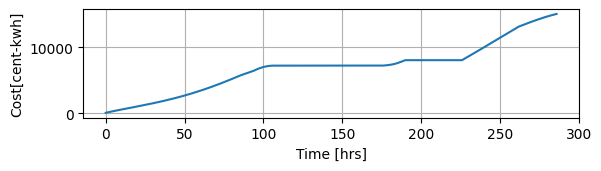

In [7]:
import matplotlib.pyplot as plt

plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(cumulativeCost)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

In [8]:
cumulativeCost[-1]

15081.46563875

In [14]:
((15081.46563875 - 14972.611166638902)/15081.46563875) * 100

0.7217764819316307

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

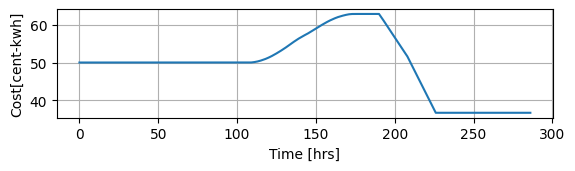

In [9]:
import matplotlib.pyplot as plt

plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot((Phydro / H2ToalE) * 100)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

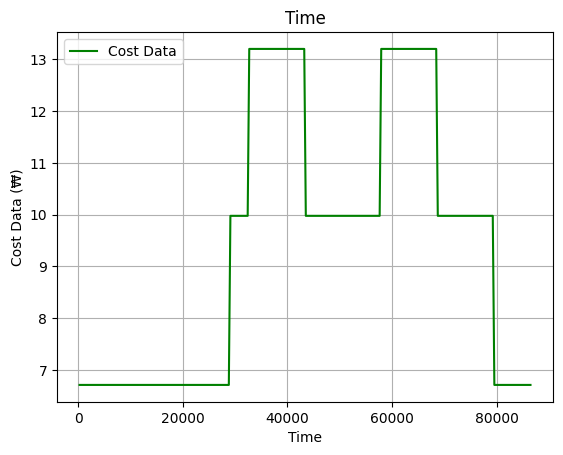

In [10]:
import matplotlib.pyplot as plt

# 시간 vs 태양광 데이터
plt.plot(time, costData, label='Cost Data', color='green')
plt.xlabel('Time')
plt.ylabel('Cost Data (₩)')
plt.title('Time')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
tvec = np.array(tvec)
tvec.shape
Ppv.shape

(287, 1)

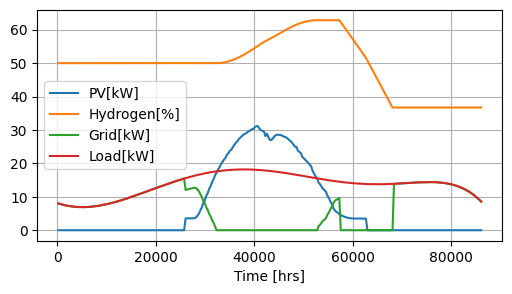

In [17]:
thour = tvec
tvec = np.array(tvec)
plt.figure(figsize=(6,3))
plt.plot(tvec, Ppv , tvec, (Phydro/(100 * 33.33)) * 100, tvec, Pgrid, tvec, Pload )
plt.grid(True)
plt.legend(['PV[kW]', 'Hydrogen[%]', 'Grid[kW]', 'Load[kW]'])
plt.xlabel('Time [hrs]')

plt.show()

In [23]:
pd.DataFrame(Ppv).to_csv("/Users/happy/Desktop/캡스톤/matlab_to_python(Hydrogen)/huri_1year_data/Ppv.csv")

In [24]:
pd.DataFrame((Phydro/(100 * 33.33)) * 100).to_csv("/Users/happy/Desktop/캡스톤/matlab_to_python(Hydrogen)/huri_1year_data/soc.csv")

In [25]:
pd.DataFrame(Pgrid).to_csv("/Users/happy/Desktop/캡스톤/matlab_to_python(Hydrogen)/huri_1year_data/Pgrid.csv")

In [26]:
pd.DataFrame(Pload).to_csv("/Users/happy/Desktop/캡스톤/matlab_to_python(Hydrogen)/huri_1year_data/Pload.csv")